**Import librerie**

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image

print(torch.__version__)
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.4.1+cu121
True
cuda:0


In [3]:
checkpoint_path = '/kaggle/working/checkpoint.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Extract the model state dict
model_state_dict = checkpoint['model_state_dict']

# Save only the model state dict
torch.save(model_state_dict, 'U-Net_ASPP_19.pth')

<ipython-input-3-5a1d64b37efd>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [3]:
#os.remove('/kaggle/working/checkpoint.pth')
#os.remove('/kaggle/working/training_history.json')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/checkpoint.pth'

# Dataset

In [2]:
remapping = {
    
        0: 255,# void
        1: 255,
        2: 255,
        3: 255,
        4: 255,
        5: 255,
        6: 255,
        7: 0,
        8: 1,
        9: 255,
        10: 255,
        11: 2,
        12: 3,
        13: 4,
        14: 255,
        15: 255,
        16: 255,
        17: 5,
        18: 255,
        19: 6,
        20: 7,        
        21: 8,
        22: 9,
        23: 10,
        24: 11,
        25: 12,
        26: 13,
        27: 14,
        28: 15,
        29: 255,
        30: 255,
        31: 16,
        32: 17,
        33: 18
    
    }

class_dict = {
    0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall',
    4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain',
    10: 'sky', 11: 'person', 12: 'rider', 13: 'car', 14: 'truck',
    15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle', 255: 'void'

}

In [ ]:
img = imageio.imread('/kaggle/input/cityscapes/Cityspaces/images/train/aachen/aachen_000003_000019_leftImg8bit.png')
gt = imageio.imread('/kaggle/input/cityscapes/Cityspaces/gtFine/train/aachen/aachen_000003_000019_gtFine_labelIds.png')

gt = np.vectorize(remapping.get)(gt)# Re-mapping delle classi con 19 classi

print(img.shape, gt.shape)

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(img)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(gt, clim = [0,18])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

(1024, 2048, 3) (1024, 2048)


Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

**Directories train**

In [3]:
basepath = '/kaggle/input/cityscapes/Cityspaces'
#root = '/kaggle/input/cityscapes/Cityspaces/'
img_train_dir = os.path.join(basepath,'/images/train')
gts_train_dir = os.path.join(basepath,'/gtFine/train')

img_val_dir = os.path.join(basepath,'/images/val')
gts_val_dir = os.path.join(basepath,'/gtFine/val')

train_zones_img = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/images/train'))[1])) #creiamo una lista con tutte le città di training
train_zones_gt = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/gtFine/train'))[1])) #creiamo una lista con tutte le città di training

val_zones_img = train_zones_img[-4:]
train_zones_img = train_zones_img[:-4]

val_zones_gt = train_zones_gt[-4:]
train_zones_gt = train_zones_gt[:-4]


img_path_train = [] #lista che conterrà tutti i path dei file di immagini
for name in train_zones_img:
        mat_root = os.path.join(basepath, 'images', 'train', name)
        img_names = sorted(next(os.walk(mat_root))[2])
        for i in range(len(img_names)):
            img_path_train.append(os.path.join(mat_root, img_names[i]))
            
gt_path_train = [] #lista che contiene tutti i path dei GT
for name in train_zones_gt:
        mat_root = os.path.join(basepath, 'gtFine', 'train', name) #prendiamo solo le label per la semantic segmentation
        img_names = sorted(next(os.walk(mat_root))[2])
        img_names = list(filter(lambda k: 'labelIds.png' in k, img_names))
        for i in range(len(img_names)):
            gt_path_train.append(os.path.join(mat_root, img_names[i]))


img_path_val = [] #lista che conterrà tutti i path dei file di immagini
for name in val_zones_img:
        mat_root = os.path.join(basepath, 'images', 'train', name)
        img_names = sorted(next(os.walk(mat_root))[2])
        for i in range(len(img_names)):
            img_path_val.append(os.path.join(mat_root, img_names[i]))
            
gt_path_val = [] #lista che contiene tutti i path dei GT
for name in val_zones_gt:
        mat_root = os.path.join(basepath, 'gtFine', 'train', name) #prendiamo solo le label per la semantic segmentation
        img_names = sorted(next(os.walk(mat_root))[2])
        img_names = list(filter(lambda k: 'labelIds.png' in k, img_names))
        for i in range(len(img_names)):
            gt_path_val.append(os.path.join(mat_root, img_names[i]))



test_zones_img = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/images/val'))[1])) #creiamo una lista con tutte le città di validation
test_zones_gt = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/gtFine/val'))[1])) #creiamo una lista con tutte le città di validation

img_path_test = [] #lista che conterrà tutti i path dei file di immagini
for name in test_zones_img:
        mat_root = os.path.join(basepath, 'images', 'val', name)
        img_names = sorted(next(os.walk(mat_root))[2])
        for i in range(len(img_names)):
            img_path_test.append(os.path.join(mat_root, img_names[i]))
            
gt_path_test = [] #lista che contiene tutti i path dei GT
for name in test_zones_gt:
        mat_root = os.path.join(basepath, 'gtFine', 'val', name) #prendiamo solo le label per la semantic segmentation
        img_names = sorted(next(os.walk(mat_root))[2])
        img_names = list(filter(lambda k: 'labelIds.png' in k, img_names))
        for i in range(len(img_names)):
            gt_path_test.append(os.path.join(mat_root, img_names[i]))



print(f"Dimensione train set: {len(img_path_train)}, {len(gt_path_train)}")
print(f"Dimensione val set: {len(img_path_val)}, {len(gt_path_val)}")
print(f"Dimensione test set: {len(img_path_test)}, {len(gt_path_test)}")

Dimensione train set: 2472, 2472
Dimensione val set: 503, 503
Dimensione test set: 500, 500


**Dataset class override**

In [4]:
from torchvision.transforms.functional import InterpolationMode

class CustomDataset(Dataset):
    def __init__(self, images_paths, gt_paths, mode='train'):
        """
        Args:
            images_paths: List of paths to the input images.
            gt_paths: List of paths to the ground truth labels.
            mode: Specifies the dataset mode: 'train', 'val', or 'test'.
        """
        self.image_paths = images_paths
        self.gt_paths = gt_paths
        self.mode = mode
        
    def __len__(self):
        return len(self.image_paths)

    
    def transform_train(self, image, gt):

        # Resize without random cropping
        
        image = T.functional.resize(image, (256, 512), interpolation=InterpolationMode.BILINEAR)
        gt = T.functional.resize(gt, (256, 512), interpolation=InterpolationMode.NEAREST_EXACT)
        
        '''
        # Random crop
        i, j, h, w = T.RandomCrop.get_params(image, output_size=(256, 512))
        image = T.functional.crop(image, i, j, h, w)
        gt = T.functional.crop(gt, i, j, h, w)
        
        # Random horizontal flip
        if random.random() > 0.5:
            image = T.functional.hflip(image)
            gt = T.functional.hflip(gt)

        '''
        '''
        # Random vertical flip
        if random.random() > 0.5:
            image = T.functional.vflip(image)
            gt = T.functional.vflip(gt)
        '''

        return image, gt

    def transform_val_test(self, image, gt):

        # Resize without random cropping
        image = T.functional.resize(image, (256, 512), interpolation=InterpolationMode.BILINEAR)
        gt = T.functional.resize(gt, (256, 512), interpolation=InterpolationMode.NEAREST_EXACT)

        return image, gt

    def __getitem__(self, index):
        
        # ATTENZIONE: torchvision.transforms.functional opera solo su immagini aperte con PIL
        image = Image.open(self.image_paths[index])
        gt = Image.open(self.gt_paths[index])
        # Apply transformations based on the mode
        if self.mode == 'train':
            image, gt = self.transform_train(image, gt)
        else:  # For 'val' or 'test'
            image, gt = self.transform_val_test(image, gt)

        # Convert to NumPy and torch.Tensor
        image = np.array(image).astype(np.float32) / 255.0
        gt = np.vectorize(remapping.get)(gt)# Re-mapping delle classi con 8 classi
        gt = np.array(gt)
        gt = torch.tensor(gt, dtype=torch.long)
        image = self.transform_img(image)
        
        return image, gt

    def transform_img(self, image):
     
        transform_ops = T.Compose([
                                            T.ToTensor(),
            
                                            T.Normalize(mean=(0.28881703, 0.32694227, 0.28622528), std=(0.18679116, 0.18973092, 0.18646142))
            
                                            #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        return transform_ops(image)

# Example usage:
# train_dataset = CustomDataset(train_image_paths, train_gt_paths, mode='train')
# val_dataset = CustomDataset(val_image_paths, val_gt_paths, mode='val')
# test_dataset = CustomDataset(test_image_paths, test_gt_paths, mode='test')

**Train and Validation Dataset**

In [5]:
# Get train and val dataset instances
train_dataset = CustomDataset(img_path_train, gt_path_train, mode='train')
valid_dataset = CustomDataset(img_path_val, gt_path_val, mode='val')
test_dataset = CustomDataset(img_path_test, gt_path_test, mode='test')

print(f"Dimensione train set: {len(img_path_train)}, {len(gt_path_train)}")
print(f"Dimensione val set: {len(img_path_val)}, {len(gt_path_val)}")
print(f"Dimensione test set: {len(img_path_test)}, {len(gt_path_test)}")
    
# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8)


Dimensione train set: 2472, 2472
Dimensione val set: 503, 503
Dimensione test set: 500, 500


**Check**

Single example: torch.Size([3, 256, 512]), torch.Size([256, 512])
Batch example: torch.Size([4, 3, 256, 512]),torch.Size([4, 256, 512])
Single example: torch.Size([3, 256, 512]), torch.Size([256, 512])


Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

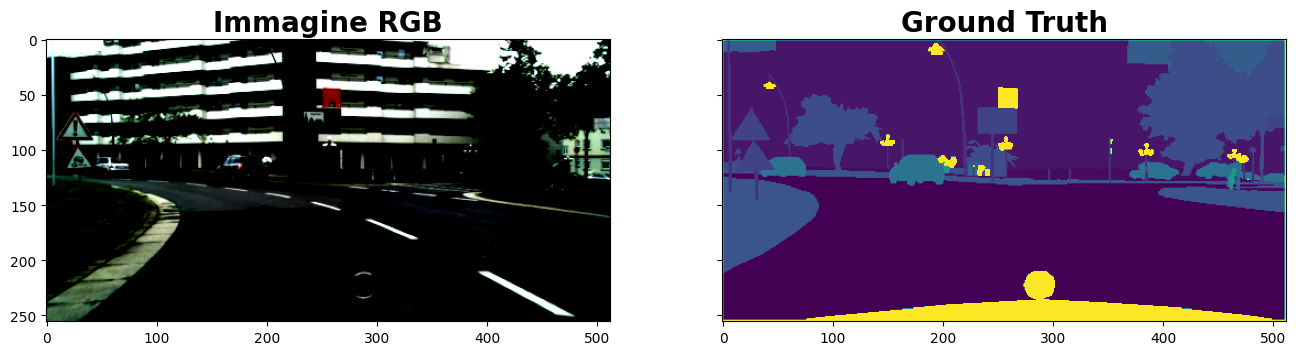

<Figure size 640x480 with 0 Axes>

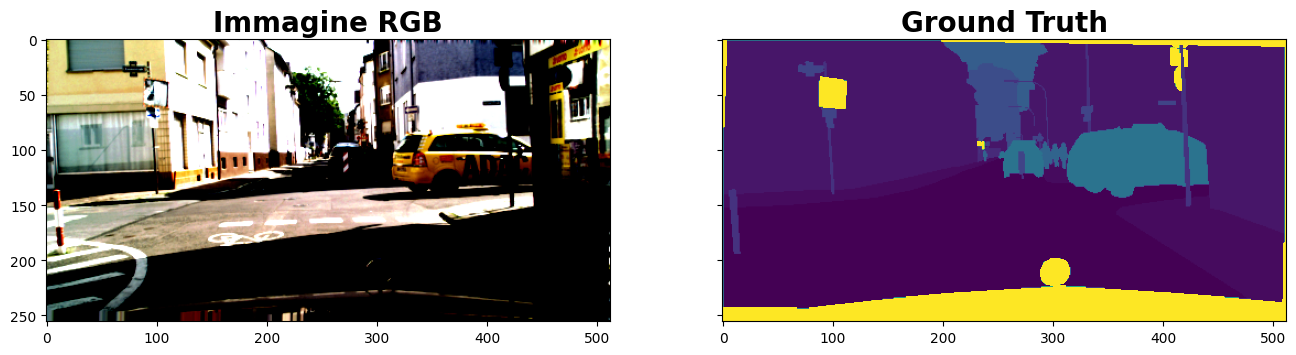

In [11]:
single_example, single_gt = train_dataset[0]

prova = np.transpose(single_example, (1, 2, 0))
#prova_gt = np.transpose(single_gt, (1, 2, 0))

print(f"Single example: {single_example.shape}, {single_gt.shape}")

for data in train_loader:
    batch_example, batch_gt = data
    break

print(f"Batch example: {batch_example.shape},{batch_gt.shape}")

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(prova)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(single_gt, clim=[0,34])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

single_example2, single_gt2 = test_dataset[0]

prova2 = np.transpose(single_example2, (1, 2, 0))
#prova_gt = np.transpose(single_gt, (1, 2, 0))

print(f"Single example: {single_example2.shape}, {single_gt2.shape}")

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(prova2)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(single_gt2, clim=[0,34])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

# Definizione Rete Neurale
<h3><center>ASPP Module Architecture</center></h3>

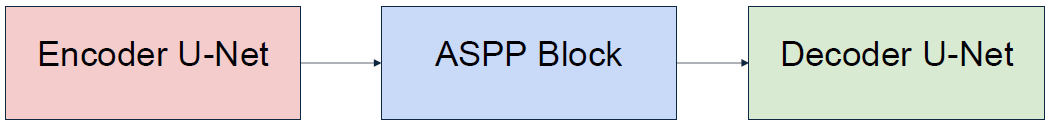


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AtrousConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(AtrousConv, self).__init__()
        padding = dilation * (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous1 = AtrousConv(in_channels, out_channels, kernel_size=1, dilation=1)
        self.atrous2 = AtrousConv(in_channels, out_channels, kernel_size=3, dilation=2)
        self.atrous4 = AtrousConv(in_channels, out_channels, kernel_size=3, dilation=4)
        self.atrous8 = AtrousConv(in_channels, out_channels, kernel_size=3, dilation=8)
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.atrous1(x)
        x2 = self.atrous2(x)
        x3 = self.atrous4(x)
        x4 = self.atrous8(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x1, x2, x3, x4, x5], dim=1)
        x = self.conv1(x)
        return self.relu(self.bn(x))
        
class UNetWithASPP(nn.Module):
    def __init__(self, num_classes):
        super(UNetWithASPP, self).__init__()
        self.num_classes = num_classes
        
        # Contrattivo
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Aggiunta ASPP qui
        self.aspp = ASPP(in_channels=1024, out_channels=512)
        
        # Espansivo
        self.expansive_11 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        
        # Applicare ASPP qui
        aspp_out = self.aspp(middle_out)  # [batch_size, 512, 16, 16]
        
        expansive_11_out = self.expansive_11(aspp_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        
        return output_out
        

num_classes = 19

model = UNetWithASPP(num_classes=num_classes)

#x = torch.randn(1, 3, 256, 512)  # Example input
#output = model(x)

#print("Output shape:", output.shape)
model = model.to(device)


**Loss, ottimizzatore e iperparametri**

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=1.5, reduction='mean'):

        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, predictions, targets):

        # Compute the cross-entropy loss per pixel
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')

        # Convert to probabilities
        p_t = torch.exp(-ce_loss)

        # Apply the focal loss formula
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss

        # Apply the specified reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
# Definisci il numero di epoche e il learning rate

epochs = 15
learning_rate = 0.0001

# Definire la loss function, che può essere custom o presa dal pacchetto nn

criterion = nn.CrossEntropyLoss(ignore_index = 255)

# definire l'ottimizzatore
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Riduce il LR ogni 10 epoche


In [8]:
#Carico il checkpoint

import json
checkpoint_path = '/kaggle/working/checkpoint.pth'

try:
    checkpoint = torch.load(checkpoint_path,  weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    with open("/kaggle/working/training_history.json", "r") as f:
        history = json.load(f)
    step_losses = history['step_losses']
    epoch_losses = history['epoch_losses']
    step_losses_val = history['step_losses_val']
    epoch_losses_val = history['epoch_losses_val']
    min_loss = checkpoint['loss']
    max_jaccard = checkpoint['jaccard']
    print(f"Checkpoint caricato: riprendo da epoch {start_epoch}")
    
except FileNotFoundError:
    checkpoint = None
    start_epoch = 0
    step_losses = []
    epoch_losses = []
    epoch_jaccards = []
    step_jaccard = []
    
    step_losses_val = []
    epoch_losses_val = []
    epoch_jaccards_val = []
    step_jaccard_val = []
    min_loss = np.inf
    max_jaccard = -np.inf  # Inizializzato a un valore minimo
    print("Checkpoint non trovato, inizio addestramento da zero.")

Checkpoint caricato: riprendo da epoch 15


In [9]:
from torchmetrics import JaccardIndex

metric = JaccardIndex(task='multiclass', num_classes=num_classes, ignore_index = 255).to(device)

# Training

In [16]:
import time
import json
from tqdm import tqdm

epoch_jaccards = []
step_jaccard = []
epoch_jaccards_val = []
step_jaccard_val = []

fit_time = time.time()

for epoch in range(epochs):
    since = time.time()
    epoch_loss = 0
    epoch_loss_val = 0
    epoch_jaccard = 0
    epoch_jaccard_val = 0
    first_batch = True  # Flag per il primo batch

    model.train()
    print(f"Epoch {epoch + 1}/{epochs}")
    with tqdm(total=len(train_loader), desc="Training") as pbar_train:  # Barra di progresso per il training
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            with torch.no_grad():
                jaccard = metric(Y_pred, Y)

            if epoch == 0 and first_batch:
                print(f"Prima loss: {loss.item()}")
                first_batch = False  # Aggiorna il flag

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_jaccard += jaccard.item()
            step_jaccard.append(jaccard.item())
            step_losses.append(loss.item())
            
            # Aggiorna la barra di progresso
            pbar_train.update(1)
            pbar_train.set_postfix({"Loss": loss.item(), "Jaccard": jaccard.item()})

    epoch_losses.append(epoch_loss / len(train_loader))
    epoch_jaccards.append(epoch_jaccard / len(train_loader))

    model.eval()
    with tqdm(total=len(val_loader), desc="Validation") as pbar_val:  # Barra di progresso per la validazione
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                Y_pred = model(X)
                loss = criterion(Y_pred, Y)
                epoch_loss_val += loss.item()
                step_losses_val.append(loss.item())

                jaccard_val = metric(Y_pred, Y)
                epoch_jaccard_val += jaccard_val.item()
                step_jaccard_val.append(jaccard_val.item())
                
                # Aggiorna la barra di progresso
                pbar_val.update(1)
                pbar_val.set_postfix({"Val Loss": loss.item(), "Val Jaccard": jaccard_val.item()})
        
    epoch_losses_val.append(epoch_loss_val / len(val_loader))
    epoch_jaccards_val.append(epoch_jaccard_val / len(val_loader))
        
    print("Epoch:{}/{}  ".format(start_epoch + epoch + 1, start_epoch + epochs),
          "Train Loss: {:.5f}  ".format(epoch_loss / len(train_loader)),
          "Val Loss: {:.5f}  ".format(epoch_loss_val / len(val_loader)),
          "Jaccard Train {:.5f}  ".format(epoch_jaccard / len(train_loader)),
          "Jaccard Val  {:.5f}  ".format(epoch_jaccard_val / len(val_loader)),
          "Time: {:.2f}m".format((time.time() - since) / 60))
    
    if ((epoch_loss_val / len(val_loader)) < min_loss) or ((epoch_jaccard_val / len(val_loader)) > max_jaccard):
        print('Checkpoint aggiornato:')
        print(f"Val Loss: {min_loss:.3f} -> {epoch_loss_val / len(val_loader):.3f}")
        print(f"Jaccard: {max_jaccard:.3f} -> {epoch_jaccard_val / len(val_loader):.3f}")
        min_loss = epoch_loss_val / len(val_loader)
        max_jaccard = epoch_jaccard_val / len(val_loader)
    
        print('Salvataggio del modello...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': start_epoch + epoch + 1,
            'loss': min_loss,
            'jaccard': max_jaccard,
        }, 'checkpoint.pth')

    # Aggiorna la history
    history = {
        'epoch_losses': epoch_losses,
        'epoch_losses_val': epoch_losses_val,
        'step_losses': step_losses,
        'step_losses_val': step_losses_val,
        'epoch_jaccards': epoch_jaccards,
        'epoch_jaccards_val': epoch_jaccards_val,
        'step_jaccard': step_jaccard,
        'step_jaccard_val': step_jaccard_val,
    }

    # Salva la history ad ogni epoca
    with open('training_history.json', 'w') as f:
        json.dump(history, f)

print('Total time: {:.2f} m' .format((time.time() - fit_time) / 60))

Epoch 1/15


Training:   0%|          | 0/618 [00:00<?, ?it/s]

Prima loss: 3.1431915760040283


Validation: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s, Val Loss=0.818, Val Jaccard=0.223]


Epoch:1/15   Train Loss: 0.78473   Val Loss: 0.66569   Jaccard Train 0.24449   Jaccard Val  0.27404   Time: 9.80m
Checkpoint aggiornato:
Val Loss: inf -> 0.666
Jaccard: -inf -> 0.274
Salvataggio del modello...
Epoch 2/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.93it/s, Val Loss=0.638, Val Jaccard=0.291]


Epoch:2/15   Train Loss: 0.54118   Val Loss: 0.51249   Jaccard Train 0.30463   Jaccard Val  0.33067   Time: 8.29m
Checkpoint aggiornato:
Val Loss: 0.666 -> 0.512
Jaccard: 0.274 -> 0.331
Salvataggio del modello...
Epoch 3/15


Validation: 100%|██████████| 126/126 [01:04<00:00,  1.94it/s, Val Loss=0.558, Val Jaccard=0.309]


Epoch:3/15   Train Loss: 0.47255   Val Loss: 0.49710   Jaccard Train 0.33582   Jaccard Val  0.34286   Time: 8.26m
Checkpoint aggiornato:
Val Loss: 0.512 -> 0.497
Jaccard: 0.331 -> 0.343
Salvataggio del modello...
Epoch 4/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.91it/s, Val Loss=0.612, Val Jaccard=0.311]


Epoch:4/15   Train Loss: 0.43406   Val Loss: 0.44040   Jaccard Train 0.35139   Jaccard Val  0.34640   Time: 8.33m
Checkpoint aggiornato:
Val Loss: 0.497 -> 0.440
Jaccard: 0.343 -> 0.346
Salvataggio del modello...
Epoch 5/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.94it/s, Val Loss=0.5, Val Jaccard=0.329]  


Epoch:5/15   Train Loss: 0.40086   Val Loss: 0.39380   Jaccard Train 0.36177   Jaccard Val  0.36525   Time: 8.30m
Checkpoint aggiornato:
Val Loss: 0.440 -> 0.394
Jaccard: 0.346 -> 0.365
Salvataggio del modello...
Epoch 6/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.92it/s, Val Loss=0.499, Val Jaccard=0.3]  


Epoch:6/15   Train Loss: 0.36874   Val Loss: 0.38494   Jaccard Train 0.37541   Jaccard Val  0.36158   Time: 8.32m
Checkpoint aggiornato:
Val Loss: 0.394 -> 0.385
Jaccard: 0.365 -> 0.362
Salvataggio del modello...
Epoch 7/15


Validation: 100%|██████████| 126/126 [01:04<00:00,  1.94it/s, Val Loss=0.403, Val Jaccard=0.368]


Epoch:7/15   Train Loss: 0.34439   Val Loss: 0.35450   Jaccard Train 0.38463   Jaccard Val  0.39161   Time: 8.32m
Checkpoint aggiornato:
Val Loss: 0.385 -> 0.354
Jaccard: 0.362 -> 0.392
Salvataggio del modello...
Epoch 8/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.92it/s, Val Loss=0.479, Val Jaccard=0.346]


Epoch:8/15   Train Loss: 0.32247   Val Loss: 0.33765   Jaccard Train 0.39455   Jaccard Val  0.40268   Time: 8.27m
Checkpoint aggiornato:
Val Loss: 0.354 -> 0.338
Jaccard: 0.392 -> 0.403
Salvataggio del modello...
Epoch 9/15


Validation: 100%|██████████| 126/126 [01:04<00:00,  1.96it/s, Val Loss=0.399, Val Jaccard=0.353]


Epoch:9/15   Train Loss: 0.30044   Val Loss: 0.32352   Jaccard Train 0.41136   Jaccard Val  0.40499   Time: 8.24m
Checkpoint aggiornato:
Val Loss: 0.338 -> 0.324
Jaccard: 0.403 -> 0.405
Salvataggio del modello...
Epoch 10/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.93it/s, Val Loss=0.431, Val Jaccard=0.326]


Epoch:10/15   Train Loss: 0.28572   Val Loss: 0.33845   Jaccard Train 0.41704   Jaccard Val  0.38162   Time: 8.27m
Epoch 11/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.93it/s, Val Loss=0.458, Val Jaccard=0.355]


Epoch:11/15   Train Loss: 0.27556   Val Loss: 0.31604   Jaccard Train 0.42461   Jaccard Val  0.41246   Time: 8.29m
Checkpoint aggiornato:
Val Loss: 0.324 -> 0.316
Jaccard: 0.405 -> 0.412
Salvataggio del modello...
Epoch 12/15


Validation: 100%|██████████| 126/126 [01:04<00:00,  1.95it/s, Val Loss=0.444, Val Jaccard=0.367]


Epoch:12/15   Train Loss: 0.25537   Val Loss: 0.32207   Jaccard Train 0.44006   Jaccard Val  0.39561   Time: 8.25m
Epoch 13/15


Validation: 100%|██████████| 126/126 [01:04<00:00,  1.95it/s, Val Loss=0.387, Val Jaccard=0.379]


Epoch:13/15   Train Loss: 0.24247   Val Loss: 0.28200   Jaccard Train 0.44649   Jaccard Val  0.42595   Time: 8.26m
Checkpoint aggiornato:
Val Loss: 0.316 -> 0.282
Jaccard: 0.412 -> 0.426
Salvataggio del modello...
Epoch 14/15


Validation: 100%|██████████| 126/126 [01:04<00:00,  1.95it/s, Val Loss=0.372, Val Jaccard=0.355]


Epoch:14/15   Train Loss: 0.22833   Val Loss: 0.28114   Jaccard Train 0.45708   Jaccard Val  0.43776   Time: 8.26m
Checkpoint aggiornato:
Val Loss: 0.282 -> 0.281
Jaccard: 0.426 -> 0.438
Salvataggio del modello...
Epoch 15/15


Validation: 100%|██████████| 126/126 [01:05<00:00,  1.93it/s, Val Loss=0.36, Val Jaccard=0.393] 


Epoch:15/15   Train Loss: 0.21910   Val Loss: 0.28655   Jaccard Train 0.46429   Jaccard Val  0.44107   Time: 8.27m
Checkpoint aggiornato:
Val Loss: 0.281 -> 0.287
Jaccard: 0.438 -> 0.441
Salvataggio del modello...
Total time: 126.03 m


Text(0, 0.5, 'CrossEntropy loss')

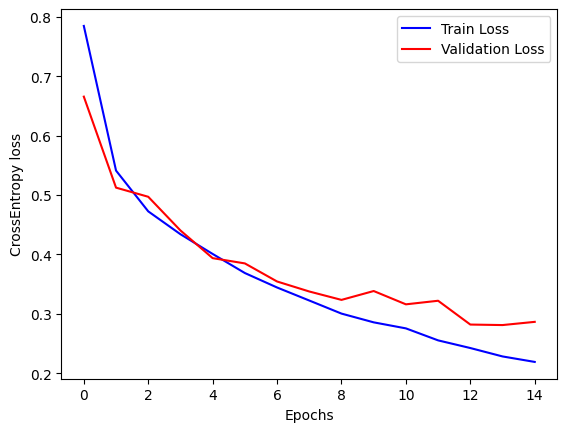

In [17]:
# Carica la history dal file JSON
with open('training_history.json', 'r') as f:
    history = json.load(f)


fig = plt.figure()
plt.plot(history['epoch_losses'], color='blue')
plt.plot(history['epoch_losses_val'], color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy loss')


**Check model predictions**

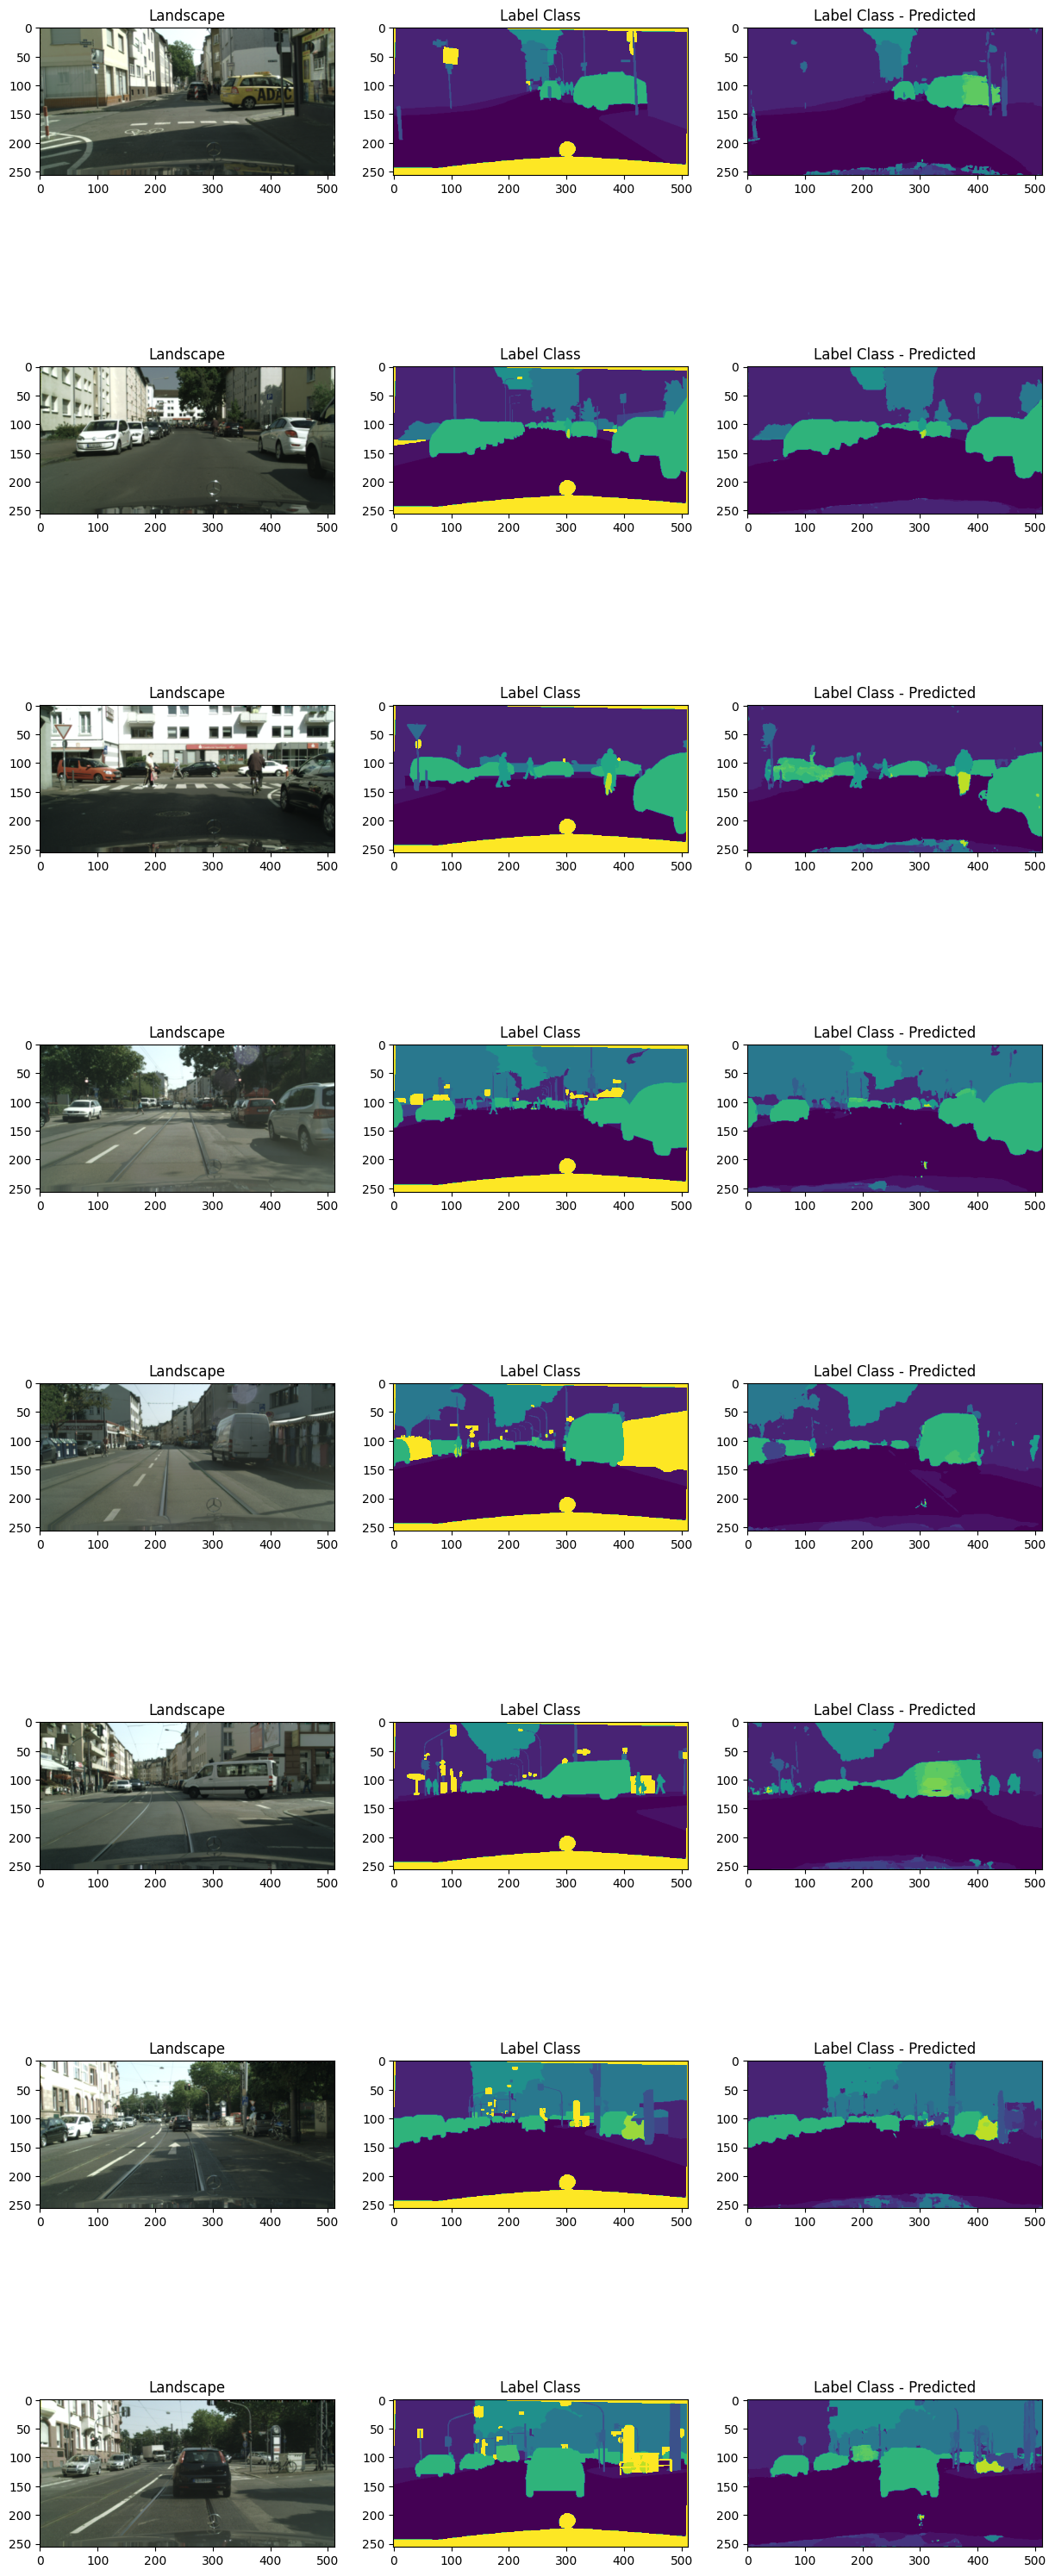

In [11]:
inverse_transform = T.Compose([
    T.Normalize(
        mean=(-0.28881703 / 0.18679116, -0.32694227 / 0.18973092, -0.28622528 / 0.18646142),
        std=(1 / 0.18679116, 1 / 0.18973092, 1 / 0.18646142)
    )
])

checkpoint = torch.load(checkpoint_path,  weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

X, Y = next(iter(test_dataloader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
Y_pred = torch.argmax(Y_pred, dim=1)

test_batch_size = (len(X))

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))
    
for i in range (test_batch_size):
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # Plot
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, clim=[0,20])
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, clim=[0,20])
    axes[i, 2].set_title("Label Class - Predicted")

**Funzione di labeling** 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_cityscapes_prediction(image, prediction, ground_truth, num_classes, ignore_index=255):
    """
    Visualizza l'immagine originale accanto alla maschera colorata basata sulla predizione,
    ignorando i pixel della GT con valore specificato (es. 255).

    Args:
        image (numpy.ndarray or torch.Tensor): Immagine originale (HxWx3).
        prediction (numpy.ndarray or torch.Tensor): Label predetta (HxW).
        ground_truth (numpy.ndarray or torch.Tensor): Ground truth (HxW).
        num_classes (int): Numero totale di classi.
        ignore_index (int): Valore della GT da ignorare nella maschera.
    """
    # Se l'immagine è un tensore, convertila in numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().detach().numpy()  # Cambia dimensioni da (C, H, W) a (H, W, C)

    # Se la predizione è un tensore, convertila in numpy
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().detach().numpy()

    # Se la GT è un tensore, convertila in numpy
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.cpu().detach().numpy()

    # Assicuriamoci che l'immagine sia in formato uint8
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Genera colori casuali per ciascuna classe
    np.random.seed(42)  # Fissa il seed per colori consistenti
    class_colors = [tuple(np.random.randint(0, 256, 3)) for _ in range(num_classes)]

    # Creiamo una maschera colorata basata sulla predizione
    mask = np.zeros_like(image, dtype=np.uint8)
    for class_id, color in enumerate(class_colors):
        # Ignora i pixel dove la GT è uguale a ignore_index
        mask[(prediction == class_id) & (ground_truth != ignore_index)] = color

    # Sovrapponi la maschera sull'immagine originale
    overlay = (0.5 * image + 0.5 * mask).astype(np.uint8)

    # Trova le classi presenti nella predizione, escludendo pixel con GT = ignore_index
    unique_classes = np.unique(prediction[ground_truth != ignore_index])
    
    # Recupera i nomi delle classi presenti
    unique_names = [class_dict.get(class_id, 'Non trovato') for class_id in unique_classes]

    # Plot dell'immagine e della maschera
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(image)
    axes[0].set_title("Immagine Originale")
    axes[0].axis('off')

    axes[1].imshow(overlay)
    axes[1].set_title("Predizione Sovrapposta")
    axes[1].axis('off')

    # Crea una legenda con le classi presenti
    unique_colors = [class_colors[class_id] for class_id in unique_classes]
    handles = [plt.Rectangle((0, 0), 1, 1, color=np.array(color)/255) for color in unique_colors]
    plt.legend(handles, unique_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()


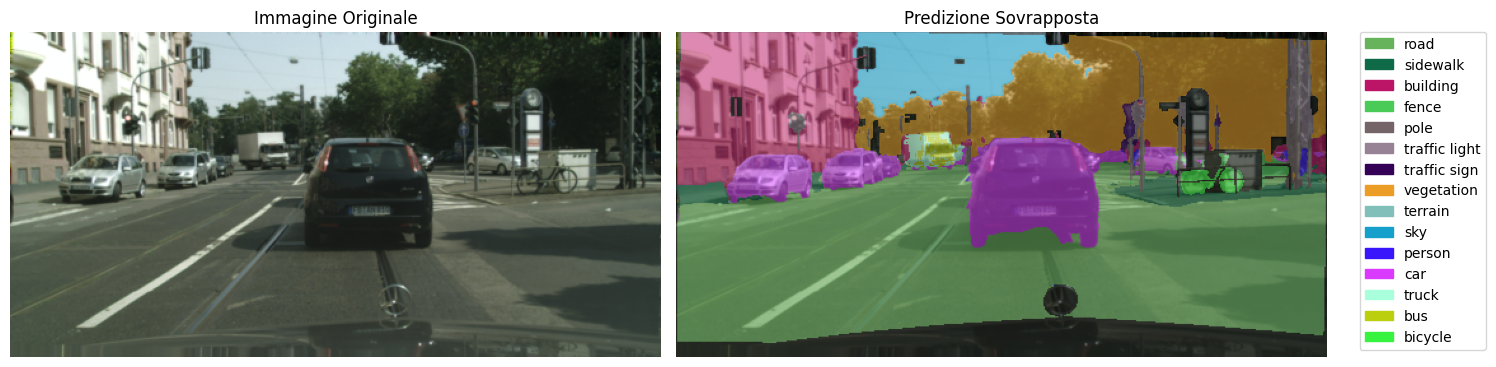

In [13]:
visualize_cityscapes_prediction(landscape, label_class_predicted, label_class, num_classes)

# Test

Mean IoU macro: 0.4146830051664322
Mean IoU micro: 0.8263283551685394
Mean IoU weighted: 0.8457617788087755


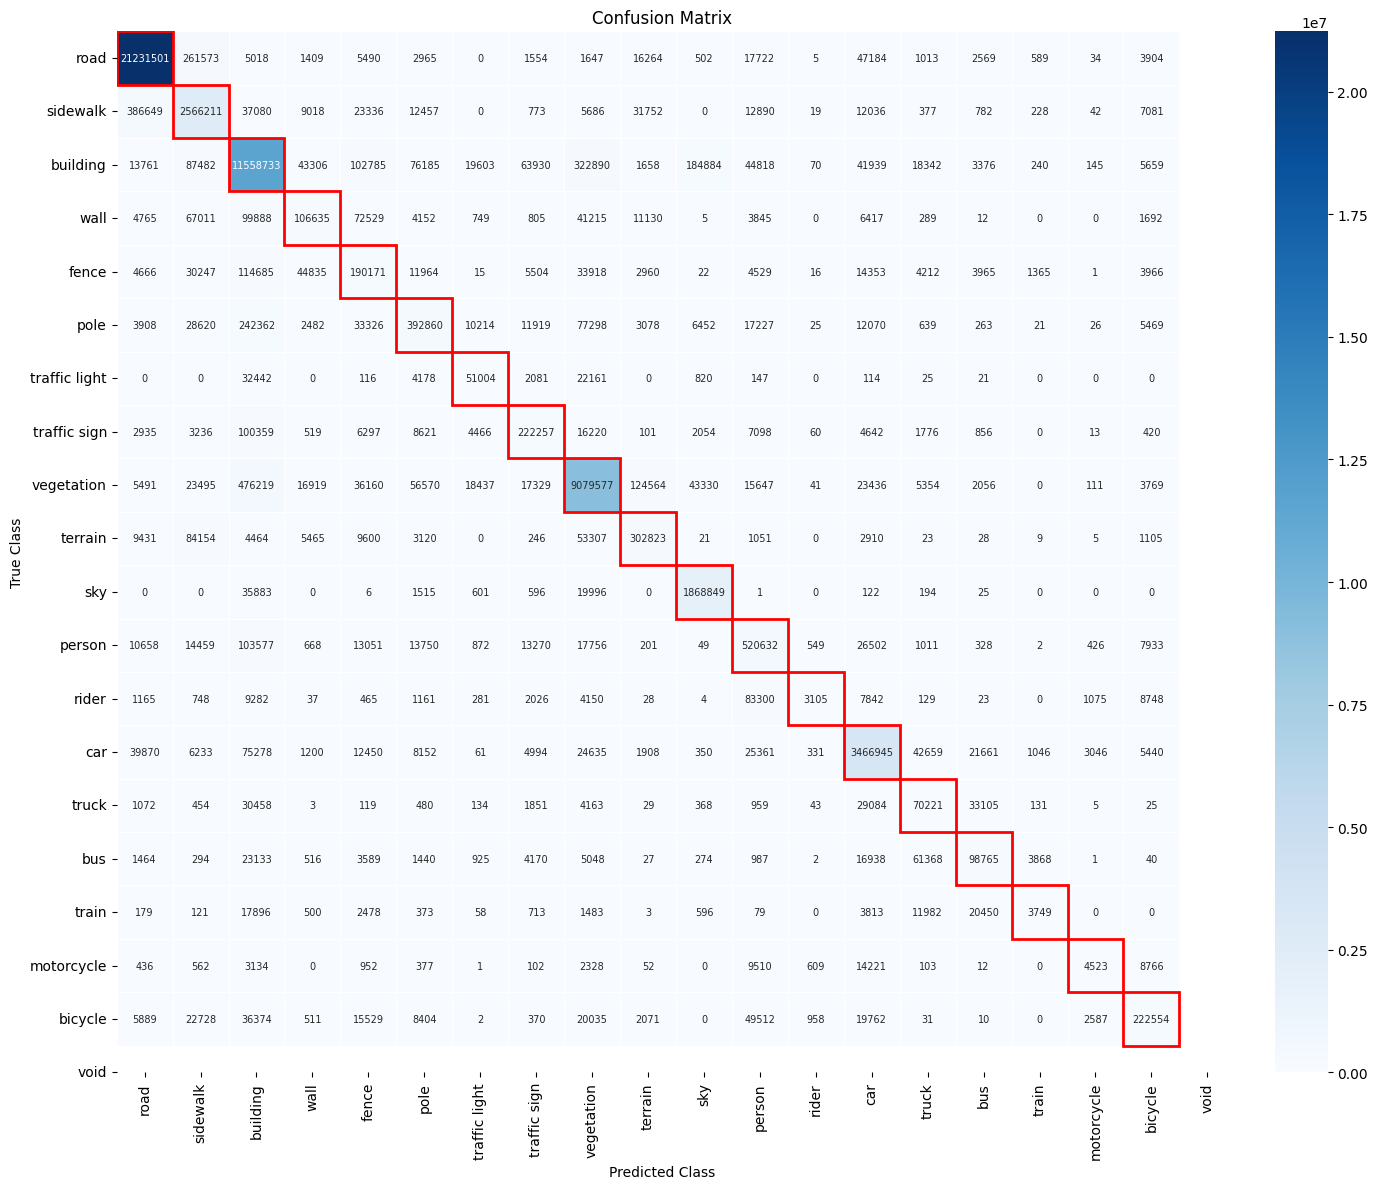

In [14]:
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix
import seaborn as sns

iou_scores = []
iou_scores_micro = []
iou_scores_weighted = []

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Matrice di confusione inizializzata

jaccard = JaccardIndex(task='multiclass', num_classes=num_classes, ignore_index = 255)
jaccard_micro = JaccardIndex(task='multiclass', average='micro', num_classes=num_classes, ignore_index = 255)
jaccard_weighted = JaccardIndex(task='multiclass', average='weighted', num_classes=num_classes, ignore_index = 255)

for X,Y in test_dataloader:

    X,Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    Y_pred = torch.argmax(Y_pred, dim=1)

    label_class = Y.cpu().detach().numpy()
    label_class_predicted = Y_pred.cpu().detach().numpy()
    

    iou_micro = jaccard_micro(Y_pred.cpu(), Y.cpu()).item()
    iou_weighted = jaccard_weighted(Y_pred.cpu(), Y.cpu()).item()
    iou = jaccard(Y_pred.cpu(), Y.cpu()).item()
    #print(iou)
    iou_scores.append(iou)
    iou_scores_micro.append(iou_micro)
    iou_scores_weighted.append(iou_weighted)

    # Aggiorna la matrice di confusione per l'immagine corrente
    conf_matrix += confusion_matrix(
        label_class.flatten(), 
        label_class_predicted.flatten(), 
        labels=np.arange(num_classes),  # Assicura che tutte le classi siano considerate
    )
    
# Plot della matrice di confusione
plt.figure(figsize=(15, 12))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt="d", 
    xticklabels=[class_dict.get(cls, str(cls)) for cls in class_dict if cls!=-255],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in class_dict if cls!=-255],
    cmap="Blues", 
    linewidths=0.5
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

# Media complessiva dell'IoU
print("Mean IoU macro:", np.mean(iou_scores))
print("Mean IoU micro:", np.mean(iou_scores_micro))
print("Mean IoU weighted:", np.mean(iou_scores_weighted))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()

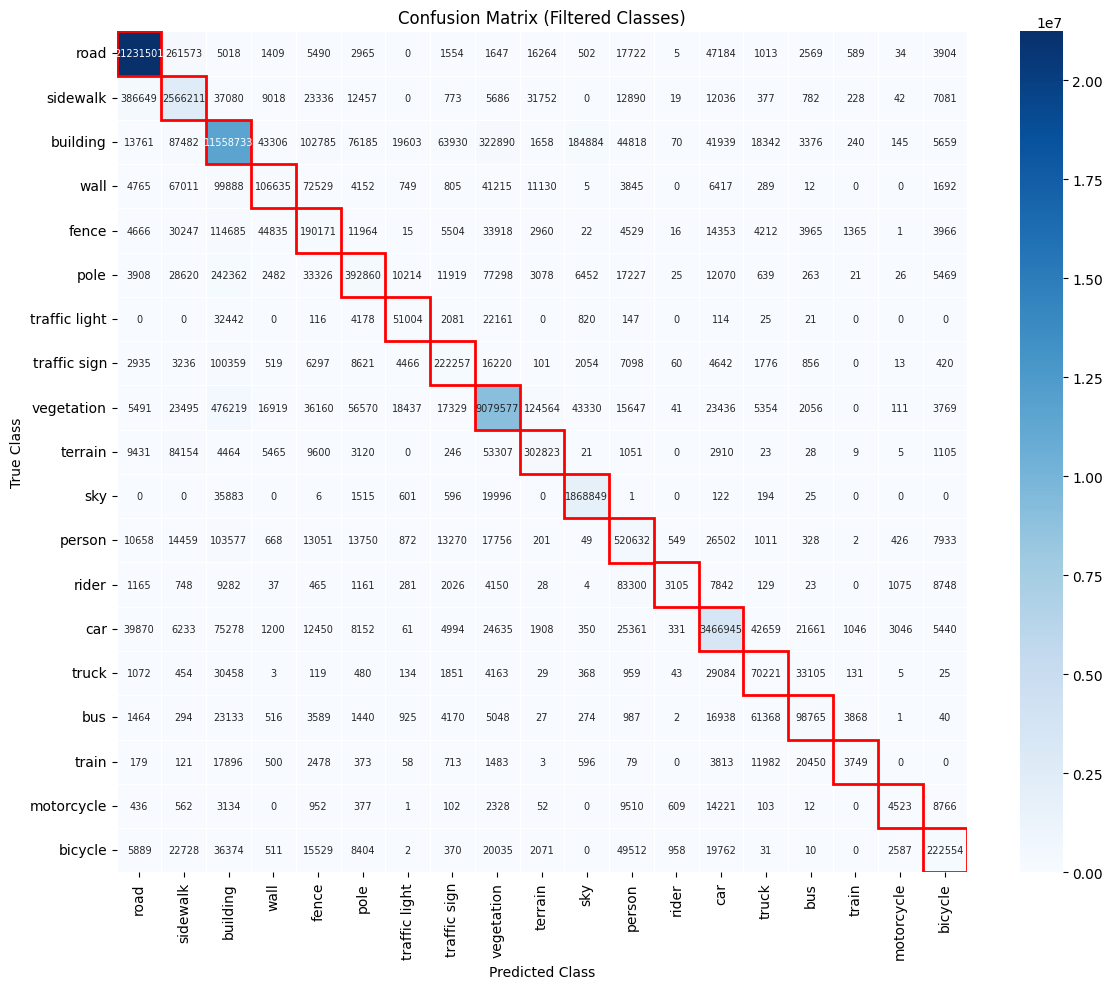

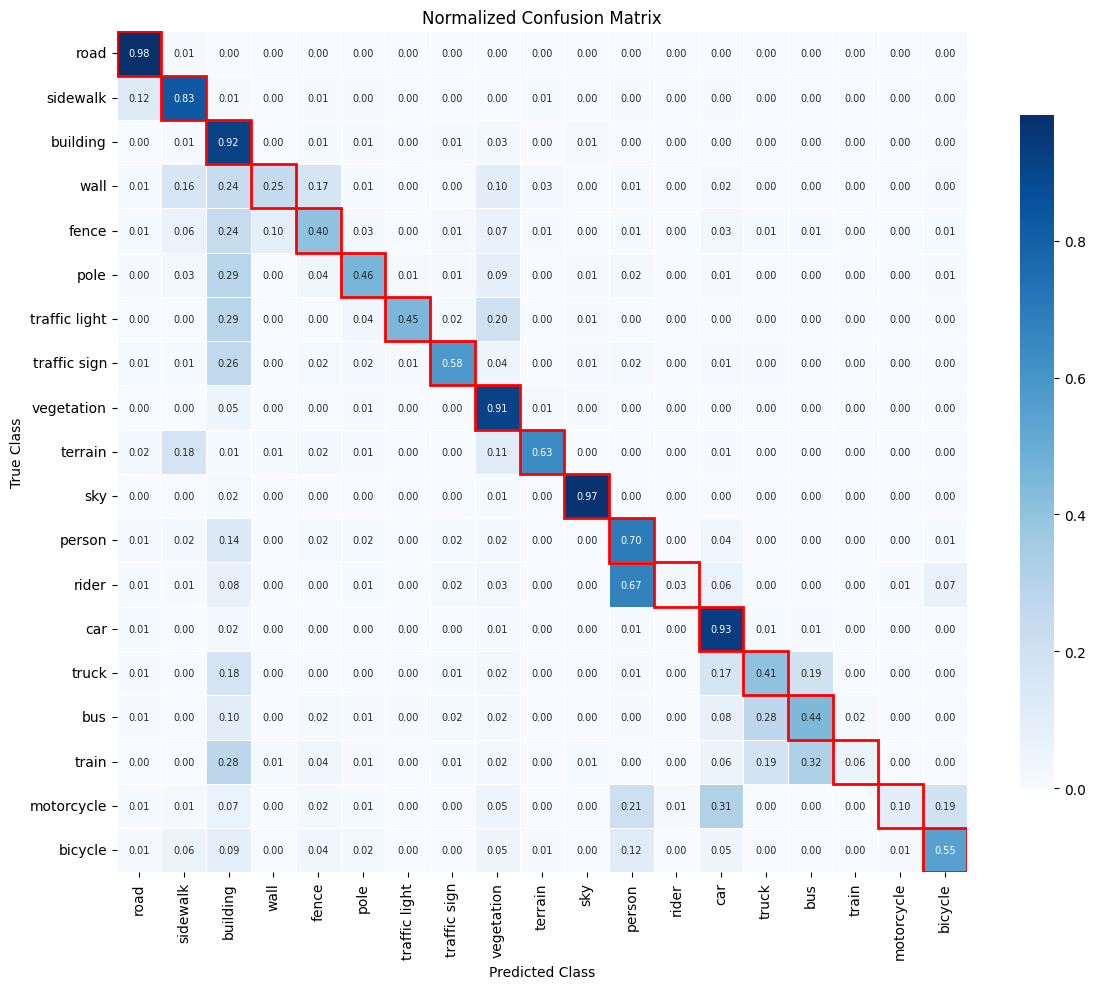

In [15]:
# Calcola la somma dei pixel per classe nella ground truth
class_frequencies = conf_matrix.sum(axis=1)

# Filtra solo le classi con almeno un certo numero di pixel
threshold = 100  # Cambia il valore a seconda delle tue esigenze
dominant_classes = [cls for cls, freq in enumerate(class_frequencies) if freq > threshold]

# Genera una matrice ridotta
conf_matrix_reduced = conf_matrix[np.ix_(dominant_classes, dominant_classes)]

# Visualizza la matrice ridotta
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_reduced, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt="d",
    xticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    cmap="Blues",
    linewidths=0.5
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Filtered Classes)")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()


# Normalizzazione per riga (valori percentuali), con gestione righe vuote
row_sums = conf_matrix_reduced.sum(axis=1, keepdims=True)
conf_matrix_normalized = np.divide(
    conf_matrix_reduced, 
    row_sums, 
    where=row_sums != 0  # Esegui la divisione solo se la somma della riga è diversa da zero
)

# Sostituisci eventuali NaN con 0 (righe con somma zero)
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)

# Trova i valori minimo e massimo della matrice normalizzata per regolare la colorbar
vmin = conf_matrix_normalized.min()
vmax = conf_matrix_normalized.max()

plt.figure(figsize=(12, 10))

# Crea la heatmap
sns.heatmap(
    conf_matrix_normalized, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt=".2f",
    xticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    cmap="Blues",  # Colormap
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},  # Aggiusta la dimensione della colorbar
    vmin=vmin,  # Imposta il minimo della colorbar
    vmax=vmax   # Imposta il massimo della colorbar
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()


In [16]:
from tabulate import tabulate

# Precision: true positives / (true positives + false positives)
precision = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=0), 1)

# Recall: true positives / (true positives + false negatives)
recall = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=1), 1)

# F1-score: harmonic mean of precision and recall (senza warning)
f1_score = np.zeros_like(precision)
valid_mask = (precision + recall) > 0
f1_score[valid_mask] = 2 * (precision[valid_mask] * recall[valid_mask]) / (precision[valid_mask] + recall[valid_mask])

# Metriche globali
micro_precision = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
micro_recall = micro_precision  # Uguale per il micro average
micro_f1 = micro_precision  # Uguale per il micro average

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1_score)

# Costruzione della tabella delle classi
table_data = []
for cls in range(num_classes):
    class_name = class_dict.get(cls, f"Class {cls}")
    pred_count = conf_matrix.sum(axis=0)[cls]  # Previsioni per questa classe
    true_count = conf_matrix.sum(axis=1)[cls]  # Veri esempi per questa classe

    if true_count == 0 and pred_count == 0:
        # Classe completamente assente nel dataset di test
        table_data.append([class_name, "-", "-", "-", "Absent in test set"])
    elif true_count == 0:
        # Classe non presente nel dataset di test (nessun vero esempio)
        table_data.append([class_name, "-", "No true instances", "-", "No true instances"])
    elif pred_count == 0:
        # Classe mai predetta
        table_data.append([class_name, "No predictions", "-", "-", "Never predicted"])
    elif f1_score[cls] == 0:
        # Classe con tutte le predizioni sbagliate
        table_data.append([
            class_name,
            f"{precision[cls]:.2f}",
            f"{recall[cls]:.2f}",
            f"{f1_score[cls]:.2f}",
            "All predictions incorrect"
        ])
    else:
        # Classe valida con metriche calcolabili
        table_data.append([
            class_name,
            f"{precision[cls]:.2f}",
            f"{recall[cls]:.2f}",
            f"{f1_score[cls]:.2f}",
            "OK"
        ])

# Tabella delle metriche globali
global_metrics = [
    ["Micro Precision", f"{micro_precision:.2f}"],
    ["Micro Recall", f"{micro_recall:.2f}"],
    ["Micro F1-score", f"{micro_f1:.2f}"],
    ["Macro Precision", f"{macro_precision:.2f}"],
    ["Macro Recall", f"{macro_recall:.2f}"],
    ["Macro F1-score", f"{macro_f1:.2f}"]
]

# Stampa delle tabelle
print("Class-wise metrics:")
print(tabulate(
    table_data,
    headers=["Class", "Precision", "Recall", "F1-score", "Status"],
    tablefmt="grid"
))

print("\nGlobal metrics:")
print(tabulate(global_metrics, headers=["Metric", "Value"], tablefmt="grid"))


Class-wise metrics:
+---------------+-------------+----------+------------+----------+
| Class         |   Precision |   Recall |   F1-score | Status   |
+===============+=============+==========+============+==========+
| road          |        0.98 |     0.98 |       0.98 | OK       |
+---------------+-------------+----------+------------+----------+
| sidewalk      |        0.8  |     0.83 |       0.81 | OK       |
+---------------+-------------+----------+------------+----------+
| building      |        0.89 |     0.92 |       0.9  | OK       |
+---------------+-------------+----------+------------+----------+
| wall          |        0.46 |     0.25 |       0.33 | OK       |
+---------------+-------------+----------+------------+----------+
| fence         |        0.36 |     0.4  |       0.38 | OK       |
+---------------+-------------+----------+------------+----------+
| pole          |        0.65 |     0.46 |       0.54 | OK       |
+---------------+-------------+----------+

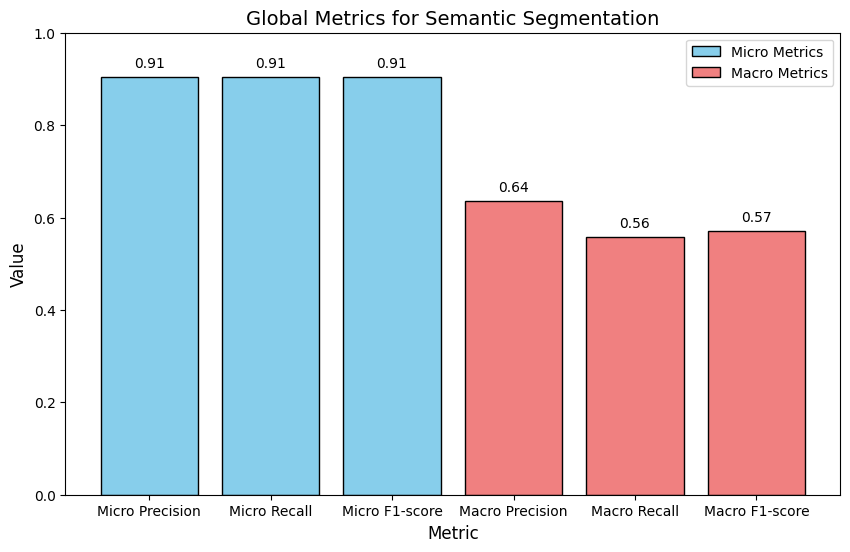

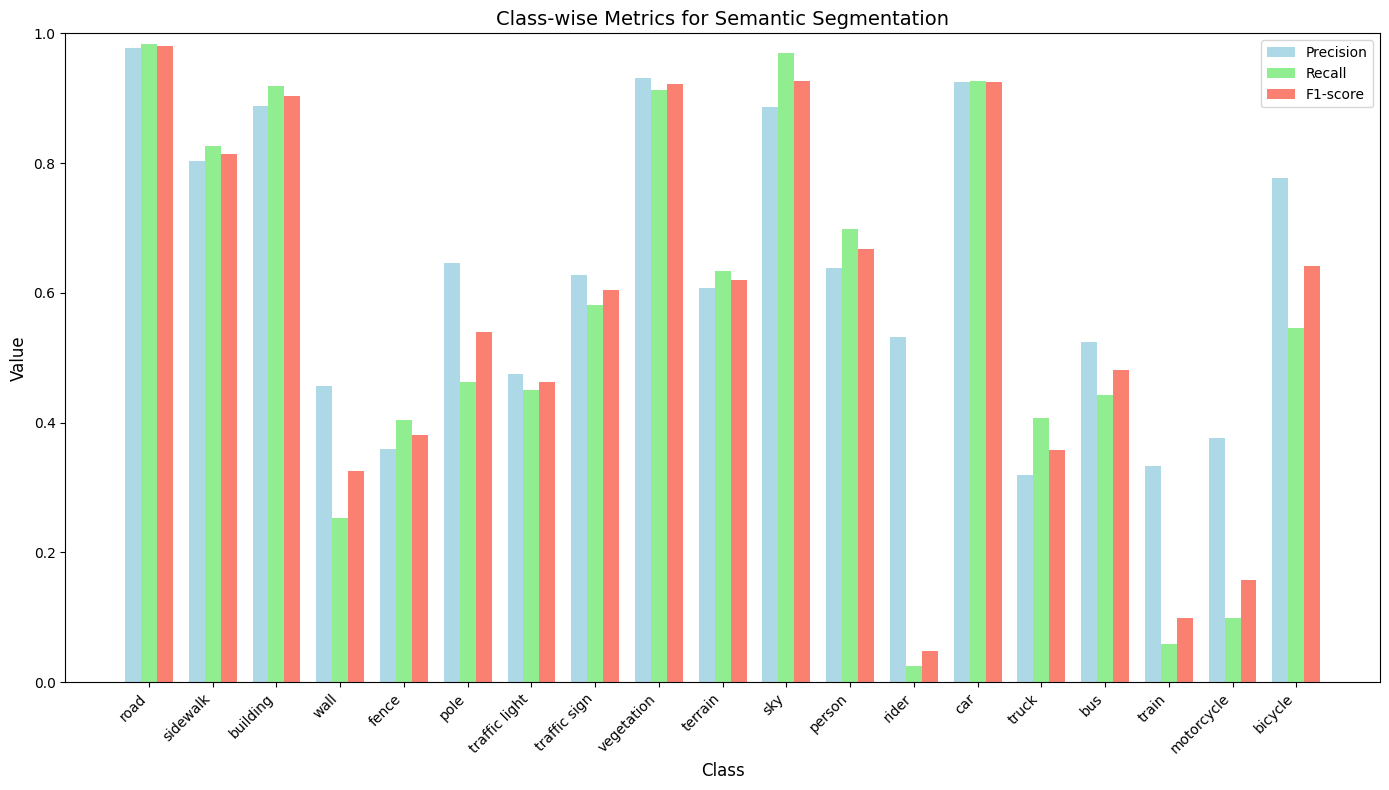

In [17]:
import matplotlib.pyplot as plt

# Dati per il grafico
global_metric_names = ["Micro Precision", "Micro Recall", "Micro F1-score", 
                       "Macro Precision", "Macro Recall", "Macro F1-score"]
global_metric_values = [micro_precision, micro_recall, micro_f1, 
                        macro_precision, macro_recall, macro_f1]

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))

# Barre per le metriche Micro
plt.bar(global_metric_names[:3], global_metric_values[:3], color='skyblue', edgecolor='black', label="Micro Metrics")

# Barre per le metriche Macro
plt.bar(global_metric_names[3:], global_metric_values[3:], color='lightcoral', edgecolor='black', label="Macro Metrics")

# Aggiungi etichette e titolo
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.ylim(0, 1)  # Le metriche sono tra 0 e 1
plt.title("Global Metrics for Semantic Segmentation", fontsize=14)

# Aggiungi valori sopra le barre
for i, v in enumerate(global_metric_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

# Aggiungi la legenda
plt.legend()

# Mostra il grafico
plt.show()

# Preparazione dei dati per il grafico
class_names = [class_dict.get(cls, f"Class {cls}") for cls in range(num_classes)]
precision_values = precision
recall_values = recall
f1_values = f1_score

x = range(len(class_names))  # Indici delle classi

# Creazione del grafico a barre raggruppate
plt.figure(figsize=(14, 8))
width = 0.25  # Larghezza delle barre

plt.bar([p - width for p in x], precision_values, width=width, label='Precision', color='lightblue')
plt.bar(x, recall_values, width=width, label='Recall', color='lightgreen')
plt.bar([p + width for p in x], f1_values, width=width, label='F1-score', color='salmon')

# Etichette asse x
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=10)

# Aggiungi etichette e titolo
plt.xlabel("Class", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.ylim(0, 1)  # Le metriche sono tra 0 e 1
plt.title("Class-wise Metrics for Semantic Segmentation", fontsize=14)
plt.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()